<a href="https://colab.research.google.com/github/kenneth-craig/academyPub/blob/main/vehicle_load_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q kaggle
from google.colab import files
files.upload()
#create a kaggle folder
!mkdir ~/.kaggle

# Go on kaggle > Account > Create New API token
# Save the json file in your laptop in a dedicated folder

# copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# Datasets available here: 
# https://www.kaggle.com/avikpaul4u/vehicle-loan-default-prediction
!kaggle datasets download -d avikpaul4u/vehicle-loan-default-prediction
!unzip vehicle-loan-default-prediction.zip
# https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009
!unzip red-wine-quality-cortez-et-al-2009.zip

Saving kaggle.json to kaggle.json
 43% 5.00M/11.6M [00:00<00:00, 10.0MB/s]
100% 11.6M/11.6M [00:00<00:00, 21.5MB/s]
Archive:  vehicle-loan-default-prediction.zip
  inflating: Data Dictionary.xlsx    
  inflating: test.csv                
  inflating: train.csv               
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 9.39MB/s]
Archive:  red-wine-quality-cortez-et-al-2009.zip
  inflating: winequality-red.csv     


In [ ]:
!pwd
!ls

In [6]:
# Here is a sumup of all the manipulation we did in order to load the dataset 
# and to add some complexity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns
import itertools
import scipy.stats as ss
from imblearn.over_sampling import SMOTE

In [ ]:
# Skip generating new FEATURE for now
"""
def citric_acid_cat(x):
  if x < 0.21 :
    return 'A'
  elif x < 0.3 :
    return 'B'
  else:
    return 'C'
"""

In [7]:
df = pd.read_csv('/content/train.csv')

In [ ]:
#print(df)
df.dtypes

In [ ]:
"""
Ignore feature engineering for now
df['citric_cat'] = df['citric acid'].apply(lambda x: citric_acid_cat(x))
df['Y'] = np.where(df['quality']>= 7, 1, 0)
df['fixed_acidity_cat'] = np.where(df['fixed acidity']<= 8, 0, 1)
df['volatile_acidity_cat'] = np.where(df['volatile acidity']>= 0.4, 0, 1)
temp = df.sample(n=150, random_state=919640901)
df = df.append(temp)
del(temp)
df.reset_index(drop=True, inplace=True)
df['pH2'] = np.where(df['pH'].index %15 ==0, np.nan, df['pH'])
rng = np.random.default_rng(893717398)
df = df.join(pd.Series(rng.normal(df['fixed acidity'].median(),1,len(df)), name='acidity_other'))
df['acidity_other'] = np.where(df['acidity_other'].index %2 !=0, np.nan, df['pH'])
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 
"""

In [9]:
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 

    '''   
    unix timestamp is in ns by default. 
    I divide the unix time value by 10**9 to make it seconds 
    (or 24*60*60*10**9 to make it days).
    The corresponding unit variable is passed to 
    the pd.to_datetime function. 
    Values for the (divide_by, unit) pair to select is defined by 
    the out_format parameter.
    for 1 -> out_format='datetime'
    for 2 -> out_format=anything else
    '''
    (divide_by, unit) = (10**9, 's') if out_format=='datetime' else (24*60*60*10**9, 'D')

    start_u = start.value//divide_by
    end_u = end.value//divide_by

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit=unit)

In [11]:

#PART OF SAME CODE BLOCK (PROCESS) AS TWO PREVIOUS BLOCKS
np.random.seed(919640901)
d_start = pd.to_datetime('2021-01-01')
d_end = pd.to_datetime('2021-06-30')
df['date'] = random_datetimes_or_dates(d_start, d_end, out_format='datetime', n=len(df))
df['date'] = df['date'].astype(str)

#df['citric_cat'] = np.where(df['citric_cat'] == 'C', 'Z', df['citric_cat']) # DO LATER
df['date'] = pd.to_datetime(df['date'], format= '%Y-%m-%d %H:%M:%S') 
today = pd.to_datetime('2021-10-12', format = '%Y-%m-%d')
df['time_diff'] = today - df['date']
df['day_diff'] = (df['time_diff']/np.timedelta64(1, 'D')).astype(float)
np.random.seed(919640901)
randomf1 = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')
randomf2 = pd.Series(np.random.normal(1, 0.5, len(df)), name='Random_Normal_feature2')
randomf = pd.concat([randomf1, randomf2], axis=1, ignore_index=True)
randomf.columns = ['Random_Normal_feature1', 'Random_Normal_feature2']
np.random.seed(919640901)
df['Random_Normal_feature1'] = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')
df = df.merge(randomf, how='inner', on='Random_Normal_feature1')


In [12]:
print (df)

        UNIQUEID  ...  Random_Normal_feature2
0         420825  ...                0.513313
1         537409  ...                0.975611
2         417566  ...                0.812321
3         624493  ...                0.257123
4         539055  ...               -0.536171
...          ...  ...                     ...
233149    626432  ...                0.775698
233150    606141  ...                1.217591
233151    613658  ...                0.047818
233152    548084  ...                0.781949
233153    630213  ...                0.183605

[233154 rows x 46 columns]


In [13]:
################################## NEW PART

# First of all, we need to split the data base into 3 parts:
# - One for the training part
# - One for the validation part
# - One for the temporal validation part (OOT: Out Of Time)

# Let's do the first temporal split:

# We already parsed our date feature previously (you can check with dtypes)
# Let's see the monthly number of observation
df.set_index('date').resample('M').size()

# We will use the 2 last months for the OOT validation
oot = df[df['date'] >= '2021-05-01']
# You can check if it works as you want: oot.date.min()

# Now we will keep the database without the oot:
df = df[df['date'] < '2021-05-01']
# And we will randomly split this data base in 2, one for the train and the other for the test
# As you notice we will have to validation database.
# One based on the same distribution as the train and the other from another distribution


# The random split is used with the sklean library, I decided to have 75% in train and 25% in test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state=919640901)

In [15]:
#print(train)
#print(test)
train.dtypes
test.dtypes

UNIQUEID                                         int64
DISBURSED_AMOUNT                                 int64
ASSET_COST                                       int64
LTV                                            float64
BRANCH_ID                                        int64
SUPPLIER_ID                                      int64
MANUFACTURER_ID                                  int64
CURRENT_PINCODE_ID                               int64
DATE_OF_BIRTH                                   object
EMPLOYMENT_TYPE                                 object
DISBURSAL_DATE                                  object
STATE_ID                                         int64
EMPLOYEE_CODE_ID                                 int64
MOBILENO_AVL_FLAG                                int64
AADHAR_FLAG                                      int64
PAN_FLAG                                         int64
VOTERID_FLAG                                     int64
DRIVING_FLAG                                     int64
PASSPORT_F

In [25]:
# Let's see if we have duplicated rows:
feature_analyze_duplicates = ['LOAN_DEFAULT', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV',
                              'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
                              'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
                              'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']

In [26]:
print(feature_analyze_duplicates)
len(feature_analyze_duplicates)

['LOAN_DEFAULT', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']


14

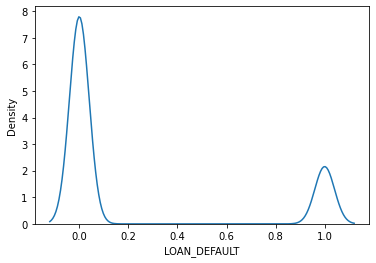

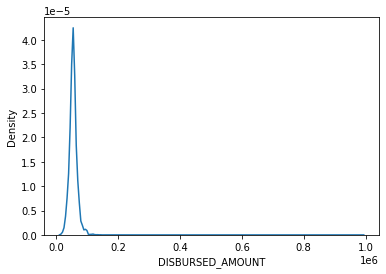

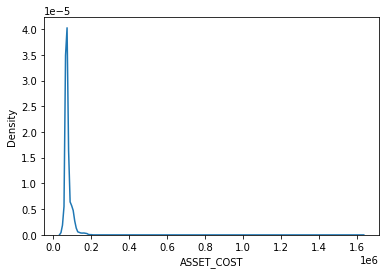

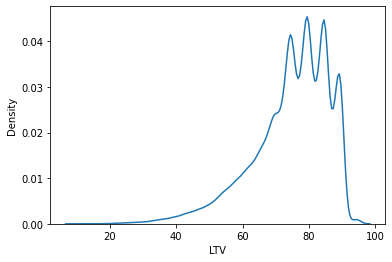

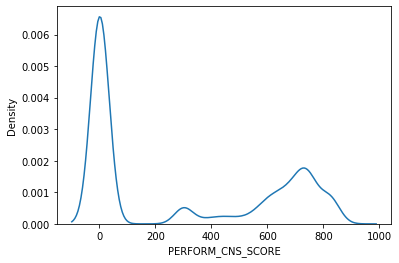

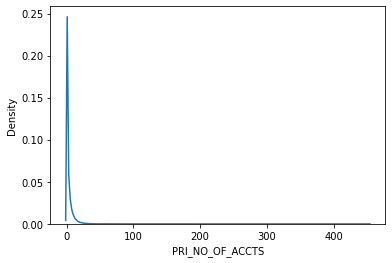

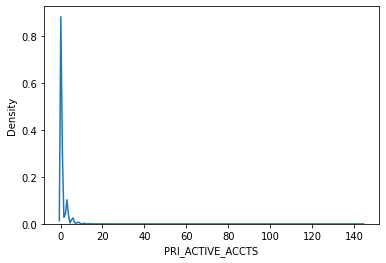

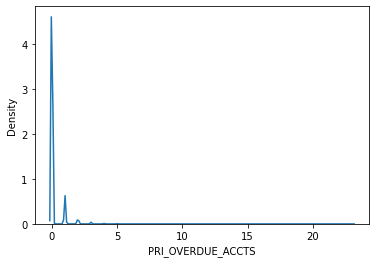

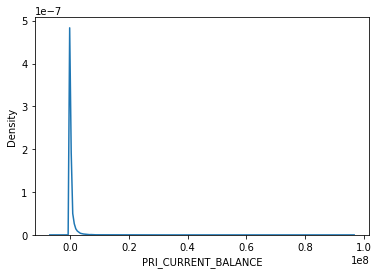

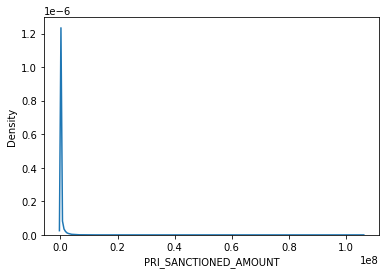

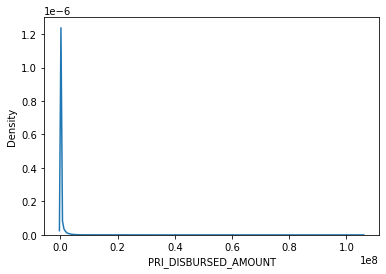

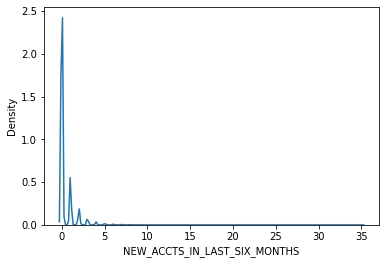

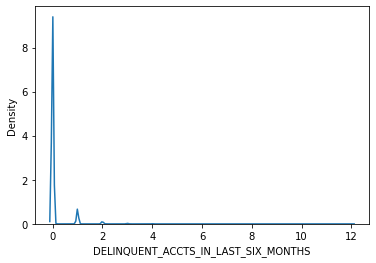

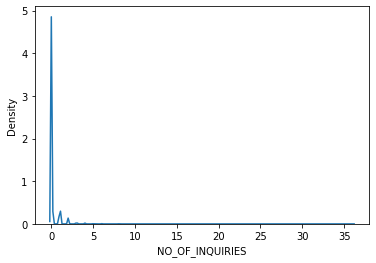

In [31]:
len(train[train.duplicated(subset = feature_analyze_duplicates, keep=False)])

def drop_duplicate_keep_first(database, list_of_features):
  database = database.drop_duplicates(subset= list_of_features, keep='first')
  return database

train = drop_duplicate_keep_first(train, feature_analyze_duplicates)

# Let's see the features distributions in order to see if we have strange / extrem values
continuous_feature_analyze_distribution = ['LOAN_DEFAULT', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV',
                                           'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
                                           'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
                                            'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']

# Plots of individual Features
for i, col in enumerate(train[continuous_feature_analyze_distribution]):
  plt.figure(i)
  sns.kdeplot(x=col, data=train)

In [ ]:
def postitive_censure(database, feature_to_censure, value_censure):
  feature = np.where(database[feature_to_censure] >= value_censure, value_censure, database[feature_to_censure])
  return feature

train['DISPURSED_AMOUNT'] = postitive_censure(train, 'DISPURSED_AMOUNT', 10)
train['ASSET_COST'] = postitive_censure(train, 'ASSET_COST', 0.3)
train['LTV'] = postitive_censure(train, 'LTV', 60)
train['PRI_NO_OF_ACCTS'] = postitive_censure(train, 'PRI_NO_OF_ACCTS', 200)
train['PRI_ACTIVE_ACCTS'] = postitive_censure(train, 'PRI_ACTIVE_ACCTS', 1.5)
train['PRI_OVERDUE_ACCTS'] = postitive_censure(train, 'PRI_OVERDUE_ACCTS', 10)
train['PRI_CURRENT_BALANCE'] = postitive_censure(train, 'PRI_CURRENT_BALANCE', 0.3)
train['PRI_SANCTIONED_AMOUNT'] = postitive_censure(train, 'PRI_SANCTIONED_AMOUNT', 60)
train['PRI_DISPURSED_AMOUNT'] = postitive_censure(train, 'PRI_DISPURSED_AMOUNT', 200)
train['NEW_ACCTS_IN_LAST_SIX_MONTHS'] = postitive_censure(train, 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 1.5)
train['DELINQUENT_IN_LAST_SIX_MONTHS'] = postitive_censure(train, 'DELINQUENT_IN_LAST_SIX_MONTHS', 200)
train['NO_OF_INQUIRIES'] = postitive_censure(train, 'NO_OF_INQUIRIES', 1.5)